Использованные ресурсы:         
https://medium.com/analytics-vidhya/demystify-transposed-convolutional-layers-6f7b61485454      

https://datascience.stackexchange.com/questions/88203/how-does-batch-normalization-work-for-convolutional-neural-networks       

https://towardsdatascience.com/batch-norm-explained-visually-how-it-works-and-why-neural-networks-need-it-b18919692739          

https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/       

https://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py      

https://pytorch.org/vision/stable/models.html      



 # Home Work 2

In this hw assignment you have to train a classifier to distinguish between different food variations.


## But first... Theory
Solve the theoretical problems. Type the solutions here, using Latex

### Problem 1 (2 points)

Compute the result of convolution operation with kernel K to a matrix X.
Convolution params are: stride=2, dilation=2, padding=1 (padding with zeros)


$        X = \begin{bmatrix}
        1 & 0 & -4 & 2 \\
        5 & 2 & 3 & 0 \\
        -1 & 0 & 1 & 4 \\
        0 & -3 & 2 & -1
    \end{bmatrix}
    K = \begin{bmatrix}
        2 & 1 \\
        -1 & -2
    \end{bmatrix}
$

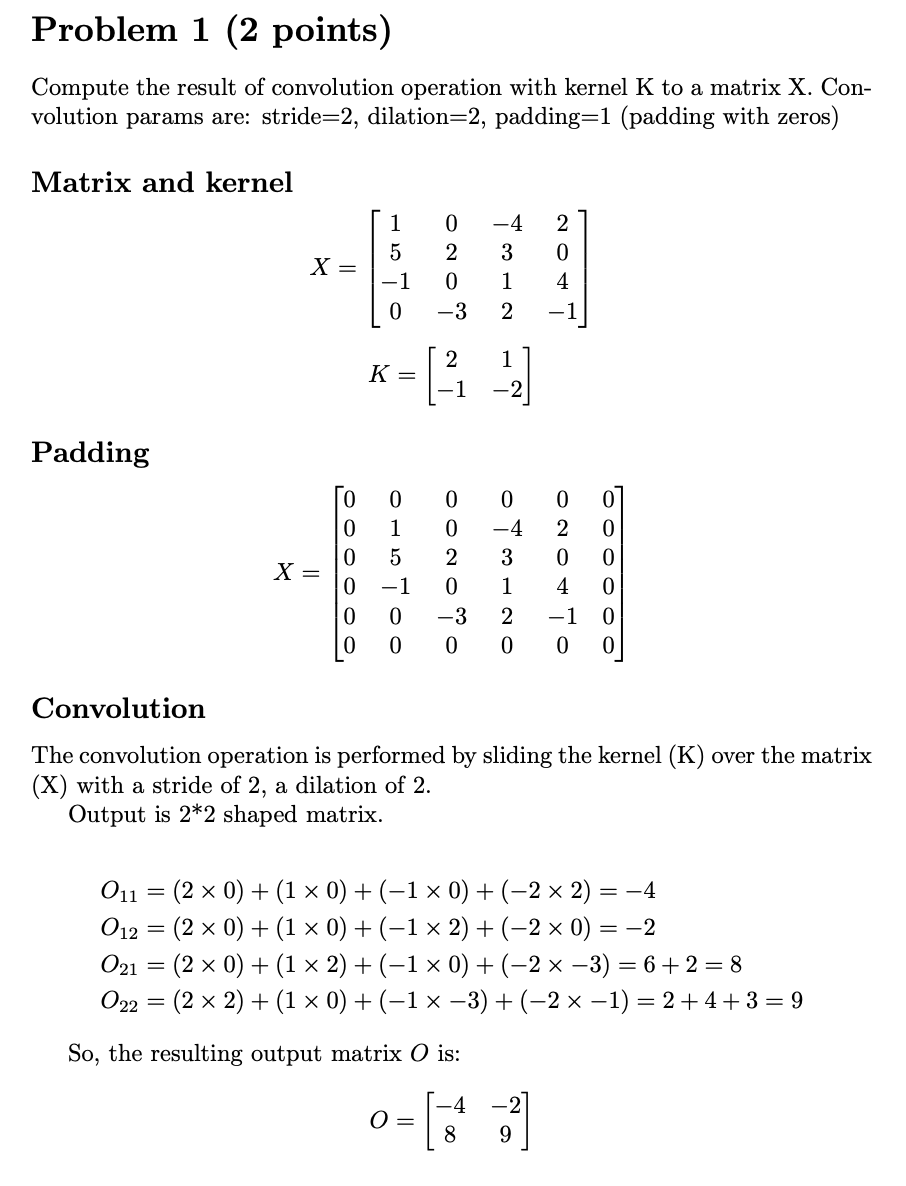

### Problem 2 (2 points)

Count the number of trainable params in nn:

        model = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=16, kernel_size=5,
                stride=2, padding=0, dilation=1, bias=True
            ),
            nn.BatchNorm2d(num_features=16),
            nn.LeakyReLU(0.1),
            nn.Conv2d(
                in_channels=16, out_channels=32, kernel_size=5,
                stride=1, padding=1, dilation=2, bias=False
            ),
            nn.BatchNorm2d(num_features=32),
            nn.Sigmoid(),
        )
  

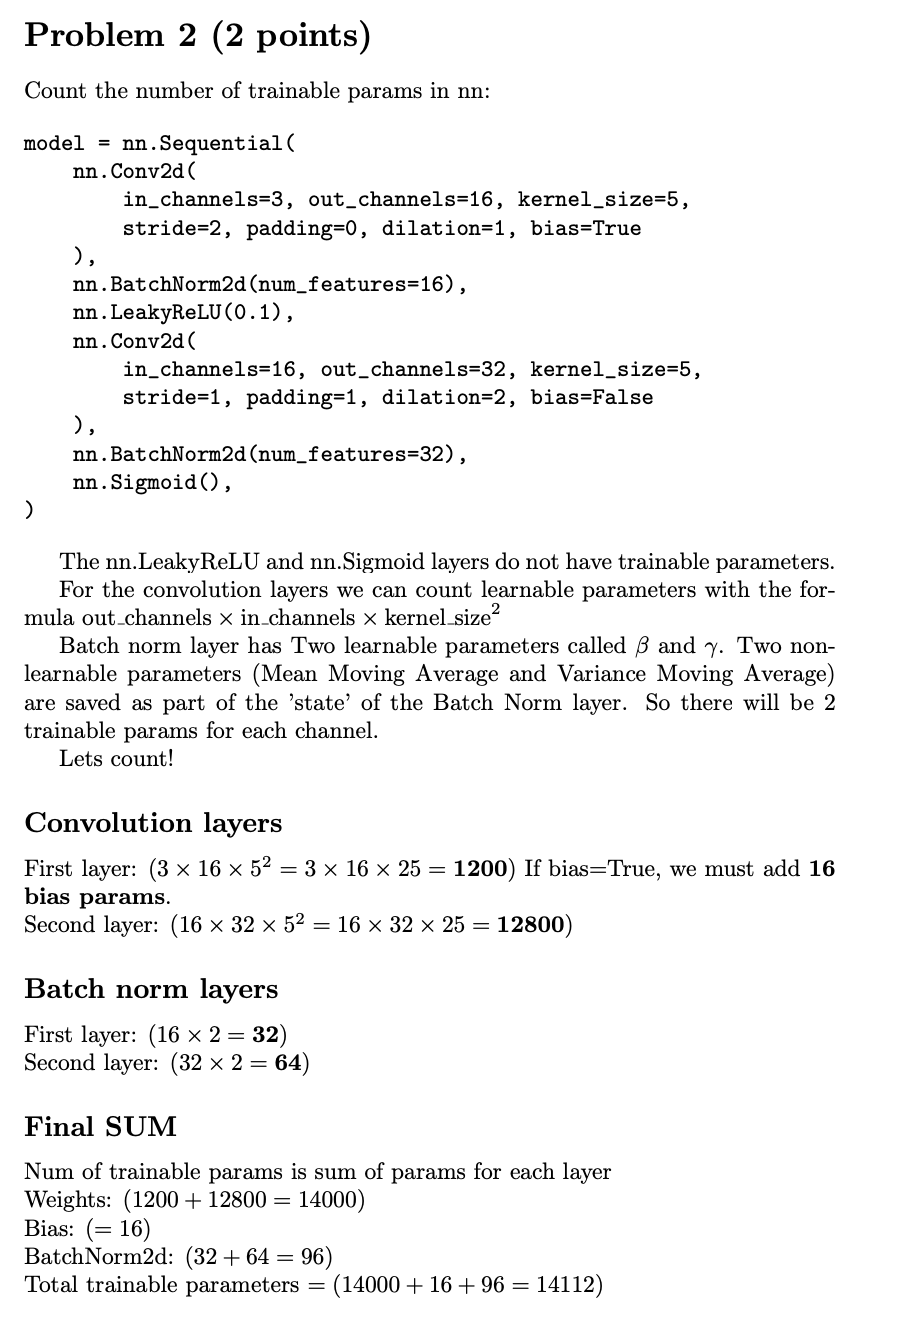

### Practical problem


Solve multicalss classification problem for Food101 dataset

####  Helper code

In [6]:
import copy
import random
import os
import shutil
import tarfile
from urllib.request import urlretrieve

import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision

from torchvision import datasets, transforms, models
from torch.utils.data import random_split, DataLoader, Dataset

pd.set_option('display.max_colwidth', None)

In [7]:
!ls -la /kaggle/input

total 8
drwxr-xr-x 3 root   root    4096 Apr  5 11:18 .
drwxr-xr-x 5 root   root    4096 Apr  5 11:18 ..
drwxr-xr-x 3 nobody nogroup    0 Apr  1 01:28 food101


In [8]:
!cp -R /kaggle/input/food101 /kaggle/working

In [10]:
!ls -la /kaggle/working/food101/food-101

total 24
drwxr-xr-x   4 root root 4096 Apr  5 11:28 .
drwxr-xr-x   3 root root 4096 Apr  5 11:28 ..
-rw-r--r--   1 root root  697 Apr  5 11:28 README.txt
drwxr-xr-x 103 root root 4096 Apr  5 11:45 images
-rw-r--r--   1 root root  399 Apr  5 11:28 license_agreement.txt
drwxr-xr-x   3 root root 4096 Apr  5 11:28 meta


### Dataloaders (1 point)


In [11]:
import os
import shutil

root_dir = '/kaggle/working/food101/food-101'

train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

with open(os.path.join(root_dir, 'meta', 'classes.txt'), 'r') as f:
    classes_names = f.read().splitlines()

for class_name in classes_names:
    class_dir_train = os.path.join(train_dir, class_name)
    os.makedirs(class_dir_train, exist_ok=True)
    class_dir_test = os.path.join(test_dir, class_name)
    os.makedirs(class_dir_test, exist_ok=True)

with open(os.path.join(root_dir, 'meta', 'train.txt'), 'r') as f:
    train_image_paths = f.read().splitlines()
with open(os.path.join(root_dir, 'meta', 'test.txt'), 'r') as f:
    test_image_paths = f.read().splitlines()

for image_path in train_image_paths:
    image = image_path+'.jpg'
    shutil.copy(os.path.join(root_dir, 'images', image), os.path.join(train_dir, image_path.split("/")[0]))

for image_path in test_image_paths:
    image = image_path+'.jpg'
    shutil.copy(os.path.join(root_dir, 'images', image), os.path.join(test_dir, image_path.split("/")[0]))


In [12]:
!ls -la /kaggle/working/food101/food-101

total 32
drwxr-xr-x   6 root root 4096 Apr  5 11:46 .
drwxr-xr-x   3 root root 4096 Apr  5 11:28 ..
-rw-r--r--   1 root root  697 Apr  5 11:28 README.txt
drwxr-xr-x 103 root root 4096 Apr  5 11:45 images
-rw-r--r--   1 root root  399 Apr  5 11:28 license_agreement.txt
drwxr-xr-x   3 root root 4096 Apr  5 11:28 meta
drwxr-xr-x 103 root root 4096 Apr  5 11:46 test
drwxr-xr-x 103 root root 4096 Apr  5 11:46 train


In [13]:
NUM_WORKERS = os.cpu_count()


def split_data(dataset, val_size=0.1, seed=42):
    """
    Creates training and testing subsamples from dataset.
    The use of generator is motivated because of reproducibility of splitting data.
    Useless when train and test already splitted

    Args:
        dataset: Input dataset, which you need to split
        val_size: The percent of the data to include in the esting subsample
        seed: The seed for the generator

    Returns:
        A tuple of (train_data, test_data).
        Example usage:
            train_set, test_set = split_data(dataset)
    """
    generator = torch.Generator().manual_seed(seed)
    train_data, test_data = random_split(dataset, [1 - val_size, val_size], generator=generator)

    return train_data, test_data


def create_dataloaders(
    train_dir: str,
    test_dir: str,
    train_transform: transforms.Compose,
    test_transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS,
    val_size = 0.1,
    seed = 27
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, result_test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4,
                             val_size = 0.2,
                             seed = 27)
  """
  # Use ImageFolder of define your Dataset class here
  #train_dataset =  # Your code here #
  train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
  test_dataset = datasets.ImageFolder(test_dir, transform=test_transform)

  test_set, result_test_set = split_data(test_dataset, val_size=val_size, seed=seed)

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_dataset,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
 )

  test_dataloader = DataLoader(
      test_set,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
 )

  result_test_dataloader = DataLoader(
      result_test_set,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
 )


 # Get class names
  class_names = train_dataset.classes

  return train_dataloader, test_dataloader, result_test_dataloader, class_names

In [14]:
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

Define transforms. You can add augmentations for better perfomance.

 You can either use Albumentation or torchvision

Don't forget to normalize images

In [15]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


In [16]:
bs = 64
root_dir = '/kaggle/working/food101/food-101'

train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')

In [17]:
train_data, test_data, result_test_data, classes = create_dataloaders(train_dir, test_dir, train_transform = train_transforms, test_transform = test_transforms, batch_size = bs, num_workers = NUM_WORKERS)

In [22]:
import warnings
warnings.filterwarnings("ignore")

In [23]:
import matplotlib.pyplot as plt

def plot_images(dataloader):
  images, labels = next(iter(dataloader))
  plt.figure(figsize=(20, 20))
  for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(torch.squeeze(images[i]).permute(1, 2, 0))
    plt.title(classes[labels[i].item()])
  plt.show()

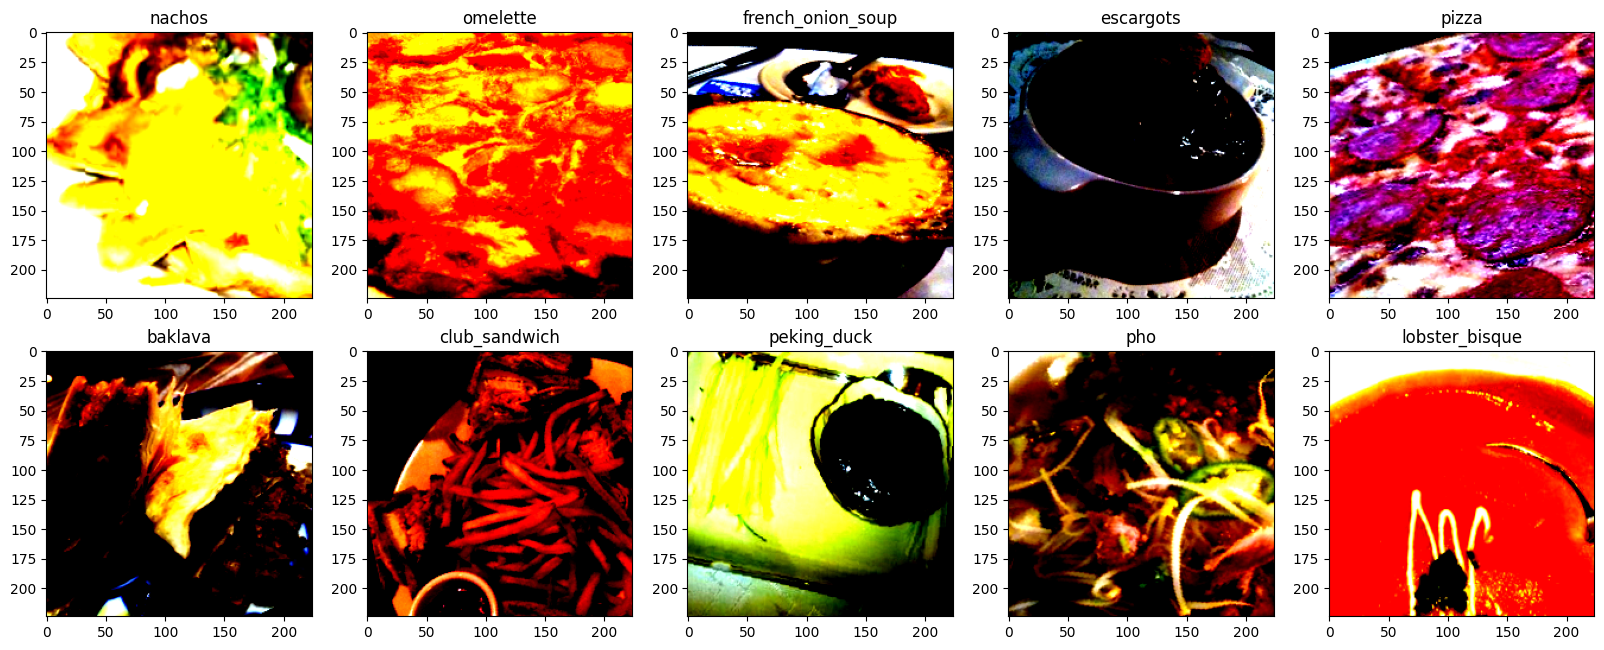

In [24]:
plot_images(train_data)

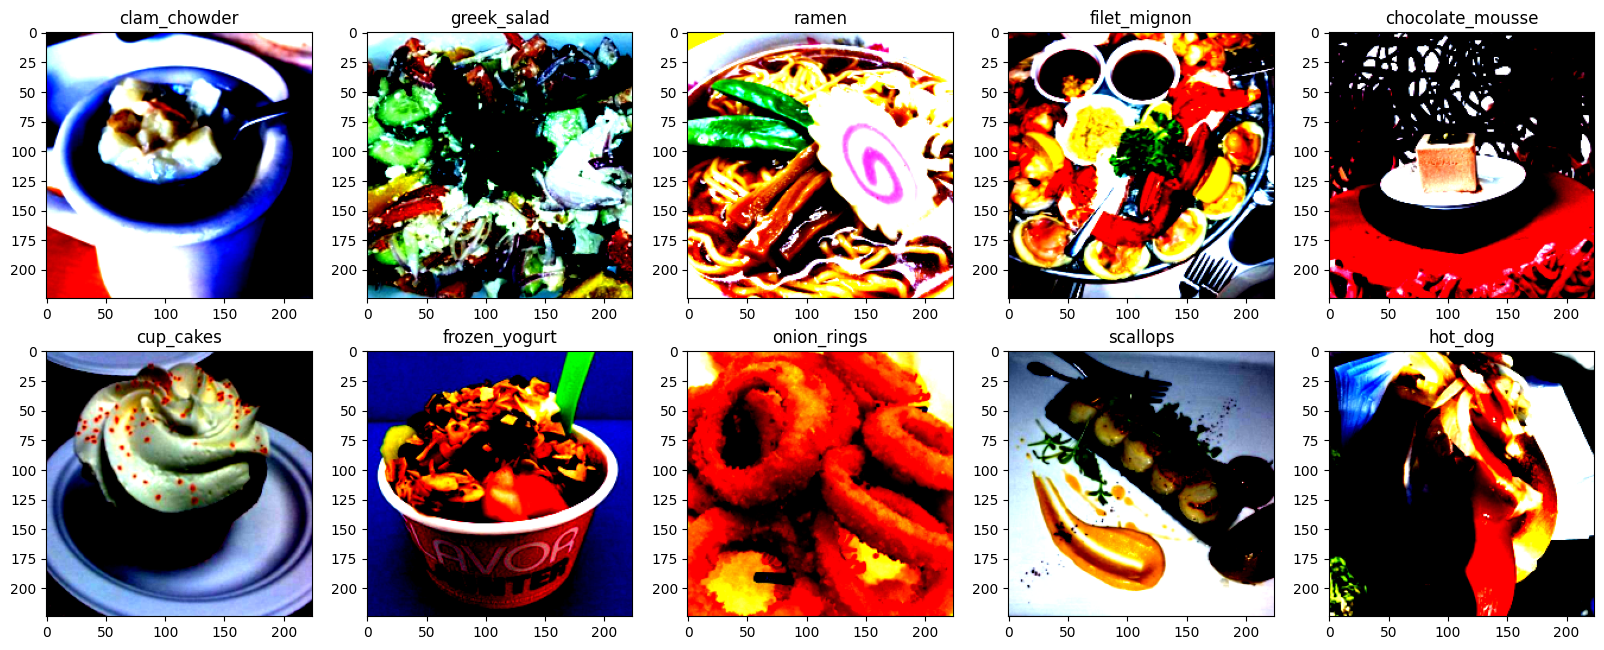

In [25]:
plot_images(test_data)

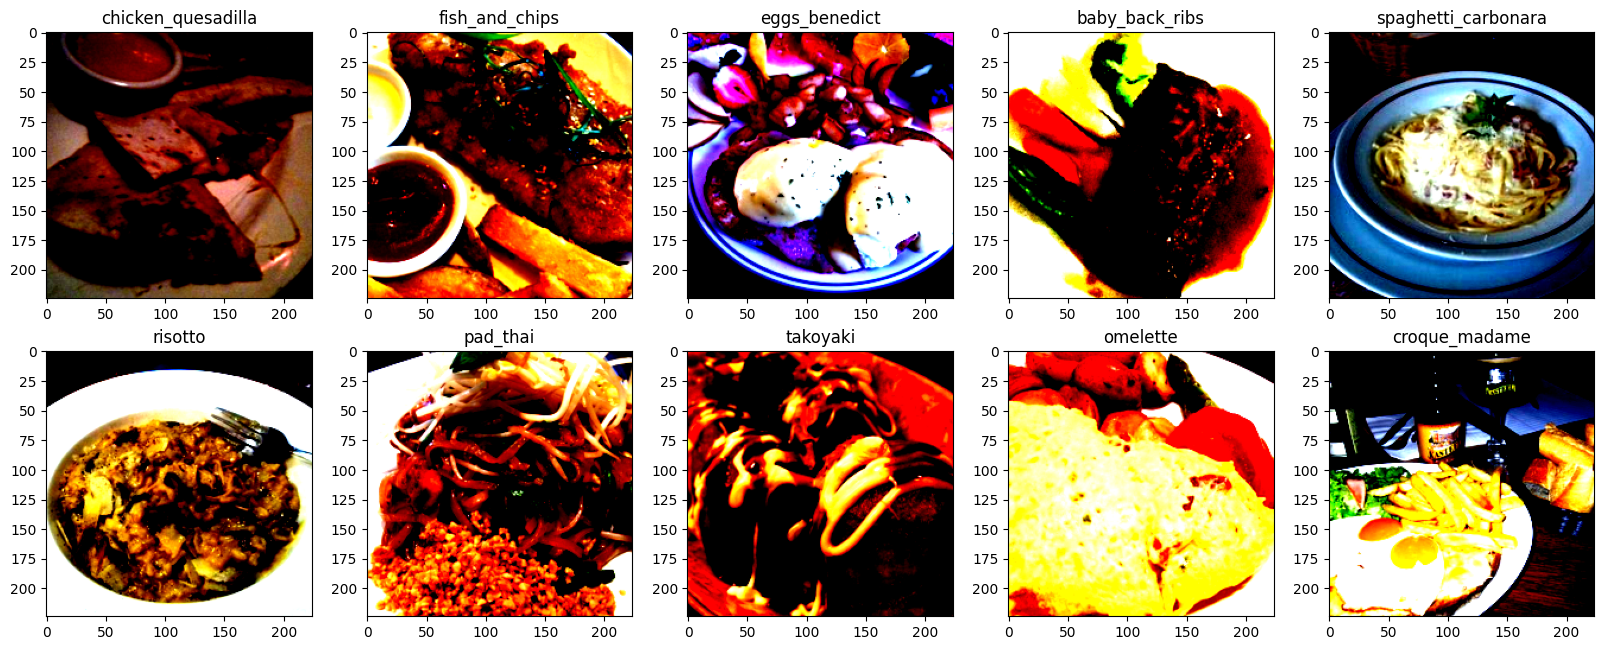

In [26]:
plot_images(result_test_data)

 #### Train function (2 points)




In [27]:
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss = 0.0
    train_accuracy = 0.0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X = X.to(device)
        y = y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        train_accuracy += (y_pred.argmax(dim=1) == y).float().mean().item()
        pass

    # Adjust metrics to get average loss and accuracy per batch
    train_loss /= len(dataloader)
    train_accuracy /= len(dataloader)

    return train_loss, train_accuracy

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    test_loss = 0.0
    test_accuracy = 0.0

    # Do the rest
    # Hint: torch.no_grad() / torch.inference_mode()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)

            y_pred = model(X)

            loss = loss_fn(y_pred, y)
            test_loss += loss.item()

            test_accuracy += (y_pred.argmax(dim=1) == y).float().mean().item()

    test_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    return test_loss, test_accuracy

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss_fn,
                }, f"{epochs}_iter.pth")

    # Return the filled results at the end of the epochs
    return results

Choose a model

In [28]:
NUM_WORKERS

4

In [29]:
len(classes)

101

In [30]:
import torchvision

model = torchvision.models.resnet50(pretrained=True)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 108MB/s] 


In [31]:
!pip install torchsummary

In [37]:
model = model.to('cuda')

In [38]:
from torchsummary import summary

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [41]:
model.fc = nn.Linear(in_features=2048, out_features=len(classes))
summary(model.to('cuda'), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Froze several layers or tune whole model

In [42]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [43]:
###
for param in model.parameters():
    param.requires_grad = False

#for param in model.layer4.parameters():
#    param.requires_grad = True
for param in model.fc.parameters():
    param.requires_grad = True

###

Model summary

In [44]:
summary(model.to('cuda'), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Train (1 point)

In [45]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 10

In [ ]:
### Get data here


In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [47]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = train(model=model,
                       train_dataloader=train_data,
                       test_dataloader=test_data,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.7054 | train_acc: 0.3702 | test_loss: 1.7128 | test_acc: 0.5603
Epoch: 2 | train_loss: 2.2844 | train_acc: 0.4483 | test_loss: 1.6101 | test_acc: 0.5818
Epoch: 3 | train_loss: 2.2066 | train_acc: 0.4655 | test_loss: 1.5453 | test_acc: 0.5974
Epoch: 4 | train_loss: 2.1427 | train_acc: 0.4795 | test_loss: 1.5961 | test_acc: 0.5905
Epoch: 5 | train_loss: 2.1225 | train_acc: 0.4840 | test_loss: 1.5115 | test_acc: 0.6040
Epoch: 6 | train_loss: 2.0956 | train_acc: 0.4908 | test_loss: 1.4471 | test_acc: 0.6177
Epoch: 7 | train_loss: 2.0757 | train_acc: 0.4945 | test_loss: 1.5228 | test_acc: 0.6000
Epoch: 8 | train_loss: 2.0450 | train_acc: 0.5025 | test_loss: 1.4217 | test_acc: 0.6271
Epoch: 9 | train_loss: 2.0253 | train_acc: 0.5059 | test_loss: 1.4802 | test_acc: 0.6174
Epoch: 10 | train_loss: 2.0120 | train_acc: 0.5079 | test_loss: 1.4437 | test_acc: 0.6234
[INFO] Total training time: 3234.958 seconds


# **Потреним еще модель у которой градиенты считаются для последнего конволюционного слоя (другую)**

In [89]:
modeleff = torchvision.models.efficientnet_b0(pretrained=True)
summary(modeleff.to('cuda'), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [91]:
modeleff.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(classes))
)

In [ ]:
modeleff

In [93]:
summary(modeleff.to('cuda'), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [100]:
for name, param in modeleff.named_parameters():
    print(name)

features.0.0.weight
features.0.1.weight
features.0.1.bias
features.1.0.block.0.0.weight
features.1.0.block.0.1.weight
features.1.0.block.0.1.bias
features.1.0.block.1.fc1.weight
features.1.0.block.1.fc1.bias
features.1.0.block.1.fc2.weight
features.1.0.block.1.fc2.bias
features.1.0.block.2.0.weight
features.1.0.block.2.1.weight
features.1.0.block.2.1.bias
features.2.0.block.0.0.weight
features.2.0.block.0.1.weight
features.2.0.block.0.1.bias
features.2.0.block.1.0.weight
features.2.0.block.1.1.weight
features.2.0.block.1.1.bias
features.2.0.block.2.fc1.weight
features.2.0.block.2.fc1.bias
features.2.0.block.2.fc2.weight
features.2.0.block.2.fc2.bias
features.2.0.block.3.0.weight
features.2.0.block.3.1.weight
features.2.0.block.3.1.bias
features.2.1.block.0.0.weight
features.2.1.block.0.1.weight
features.2.1.block.0.1.bias
features.2.1.block.1.0.weight
features.2.1.block.1.1.weight
features.2.1.block.1.1.bias
features.2.1.block.2.fc1.weight
features.2.1.block.2.fc1.bias
features.2.1.blo

In [102]:
parameters_w_grad = [
    'features.8.0.weight',
    'features.8.1.weight',
    'features.8.1.bias',
    'classifier.1.weight',
    'classifier.1.bias'
]

for name, param in modeleff.named_parameters():
    if name in parameters_w_grad:
        param.requires_grad = True
    else:
        param.requires_grad = False

for name, param in modeleff.named_parameters():
    print(name, param.requires_grad)

features.0.0.weight False
features.0.1.weight False
features.0.1.bias False
features.1.0.block.0.0.weight False
features.1.0.block.0.1.weight False
features.1.0.block.0.1.bias False
features.1.0.block.1.fc1.weight False
features.1.0.block.1.fc1.bias False
features.1.0.block.1.fc2.weight False
features.1.0.block.1.fc2.bias False
features.1.0.block.2.0.weight False
features.1.0.block.2.1.weight False
features.1.0.block.2.1.bias False
features.2.0.block.0.0.weight False
features.2.0.block.0.1.weight False
features.2.0.block.0.1.bias False
features.2.0.block.1.0.weight False
features.2.0.block.1.1.weight False
features.2.0.block.1.1.bias False
features.2.0.block.2.fc1.weight False
features.2.0.block.2.fc1.bias False
features.2.0.block.2.fc2.weight False
features.2.0.block.2.fc2.bias False
features.2.0.block.3.0.weight False
features.2.0.block.3.1.weight False
features.2.0.block.3.1.bias False
features.2.1.block.0.0.weight False
features.2.1.block.0.1.weight False
features.2.1.block.0.1.bia

In [103]:
summary(modeleff.to('cuda'), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [104]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
resultseff = train(model=modeleff,
                       train_dataloader=train_data,
                       test_dataloader=test_data,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=n_epochs,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.6436 | train_acc: 0.0096 | test_loss: 4.6438 | test_acc: 0.0096
Epoch: 2 | train_loss: 4.6445 | train_acc: 0.0099 | test_loss: 4.6450 | test_acc: 0.0102
Epoch: 3 | train_loss: 4.6430 | train_acc: 0.0098 | test_loss: 4.6442 | test_acc: 0.0096
Epoch: 4 | train_loss: 4.6431 | train_acc: 0.0100 | test_loss: 4.6442 | test_acc: 0.0099
Epoch: 5 | train_loss: 4.6426 | train_acc: 0.0100 | test_loss: 4.6441 | test_acc: 0.0098
Epoch: 6 | train_loss: 4.6423 | train_acc: 0.0095 | test_loss: 4.6440 | test_acc: 0.0095
Epoch: 7 | train_loss: 4.6435 | train_acc: 0.0090 | test_loss: 4.6442 | test_acc: 0.0097
Epoch: 8 | train_loss: 4.6421 | train_acc: 0.0099 | test_loss: 4.6445 | test_acc: 0.0096
Epoch: 9 | train_loss: 4.6437 | train_acc: 0.0099 | test_loss: 4.6439 | test_acc: 0.0103
Epoch: 10 | train_loss: 4.6447 | train_acc: 0.0091 | test_loss: 4.6451 | test_acc: 0.0099
[INFO] Total training time: 2918.763 seconds


### Results (2 points in total)
Plot train and val losses

Inference model on unique subset of images


It must be very obvious that you specificaly using images that model has never seen neither during training nor evaluation steps




#### Graphs (1 point)
Plot graphs for train and val loss



Для ResNet50 с обучением только классификатора

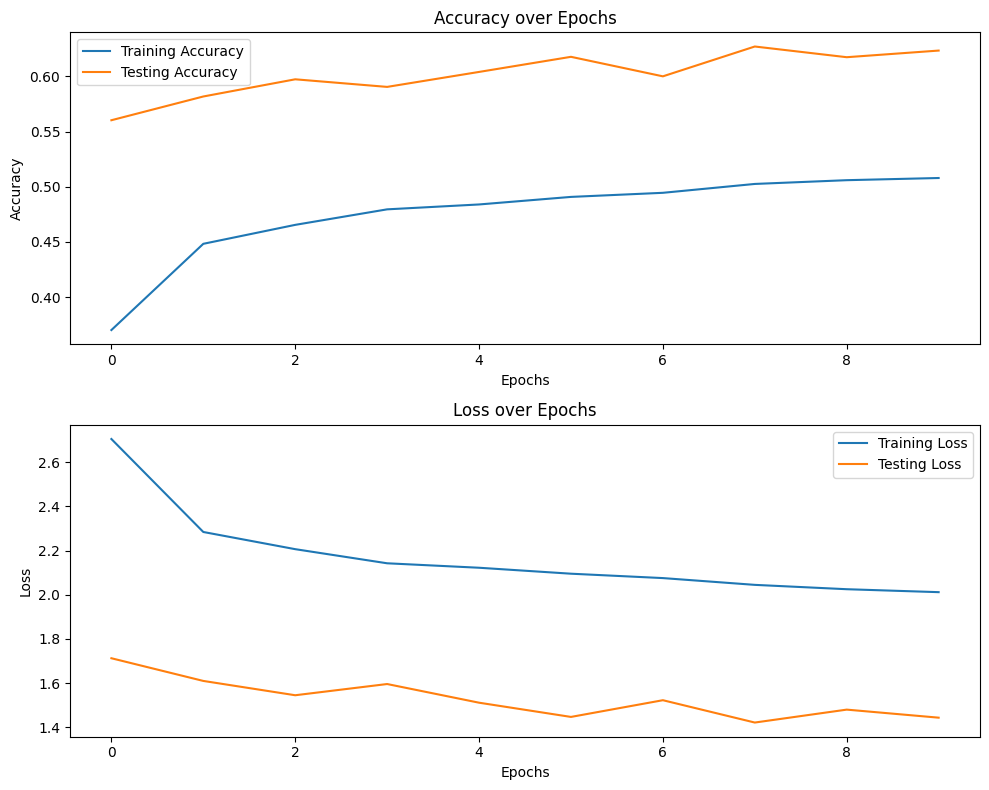

In [48]:
#для resnet
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(results['train_acc'], label='Training Accuracy')
axs[0].plot(results['test_acc'], label='Testing Accuracy')
axs[0].set_title('Accuracy over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(results['train_loss'], label='Training Loss')
axs[1].plot(results['test_loss'], label='Testing Loss')
axs[1].set_title('Loss over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

для efficientnet

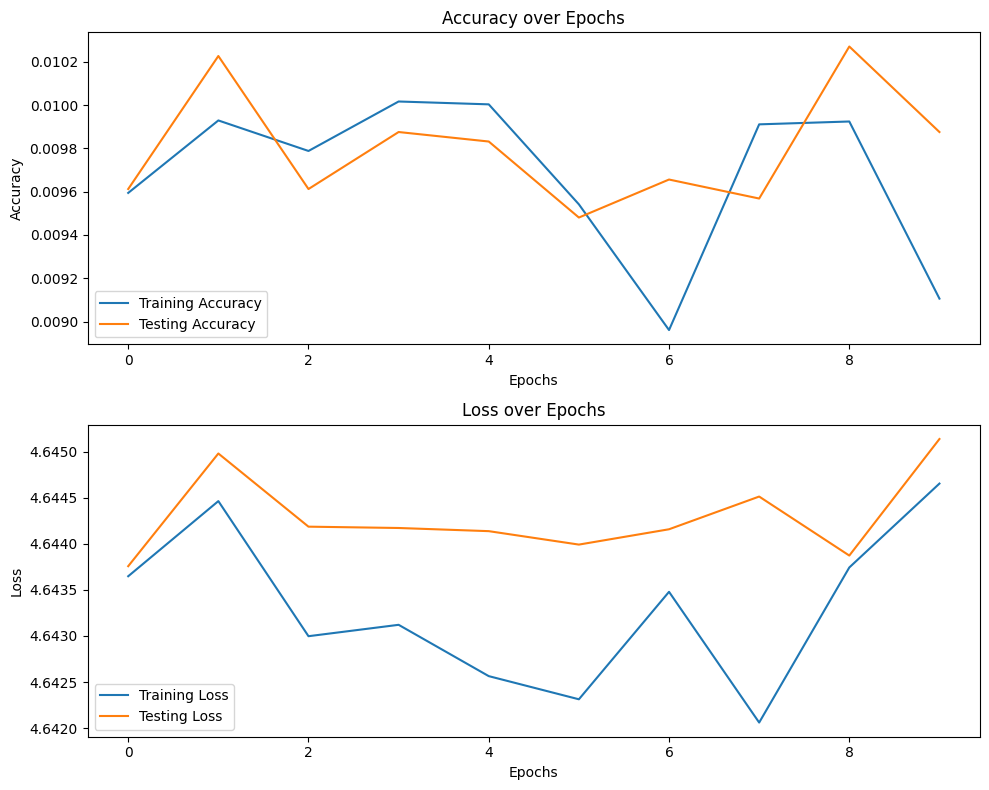

In [105]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(resultseff['train_acc'], label='Training Accuracy')
axs[0].plot(resultseff['test_acc'], label='Testing Accuracy')
axs[0].set_title('Accuracy over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

axs[1].plot(resultseff['train_loss'], label='Training Loss')
axs[1].plot(resultseff['test_loss'], label='Testing Loss')
axs[1].set_title('Loss over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

#### Demonstration (1 point)

Show model prediction on several images

In [135]:
def predictions_res(model, dataloader, classes):
    model.eval()
    num_images = 20

    # Calculate the number of rows and columns for the subplots
    num_rows = 4
    num_cols = num_images // num_rows
    if num_images % num_rows != 0:
        num_cols += 1

    data_iter = iter(dataloader)
    images, true_labels = next(data_iter)

    images = images.to(next(model.parameters()).device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted_labels = torch.max(outputs, 1)

    images = images.cpu().numpy()
    true_labels = true_labels.cpu().numpy()
    predicted_labels = predicted_labels.cpu().numpy()

    # Create a figure and a set of subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))
    axes = axes.flatten() # Flatten the axes array to iterate over it easily

    for idx, ax in enumerate(axes[:num_images]): # Ensure we don't go out of bounds
        img = images[idx].transpose((1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())

        ax.imshow(img)
        ax.axis('off')
        title_color = 'green' if classes[true_labels[idx]] == classes[predicted_labels[idx]] else 'red'
        ax.set_title(f"{classes[true_labels[idx]]} ({classes[predicted_labels[idx]]})", color=title_color)

    # Remove any unused subplots
    for ax in axes[num_images:]:
        ax.remove()

    plt.show()


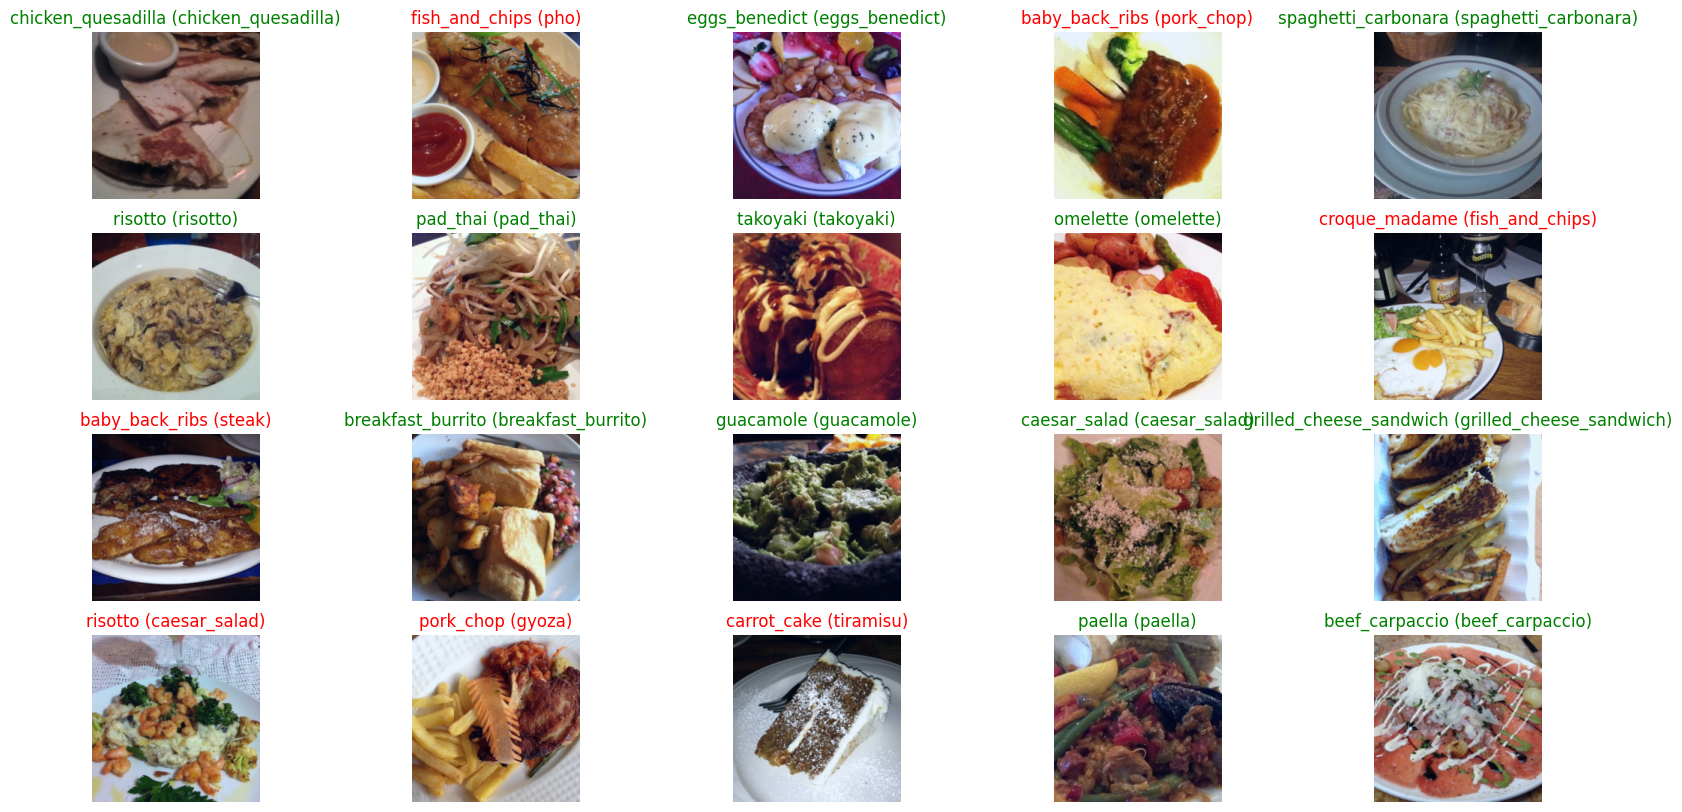

In [136]:
#для resnet50
predictions_res(model, result_test_data, classes)

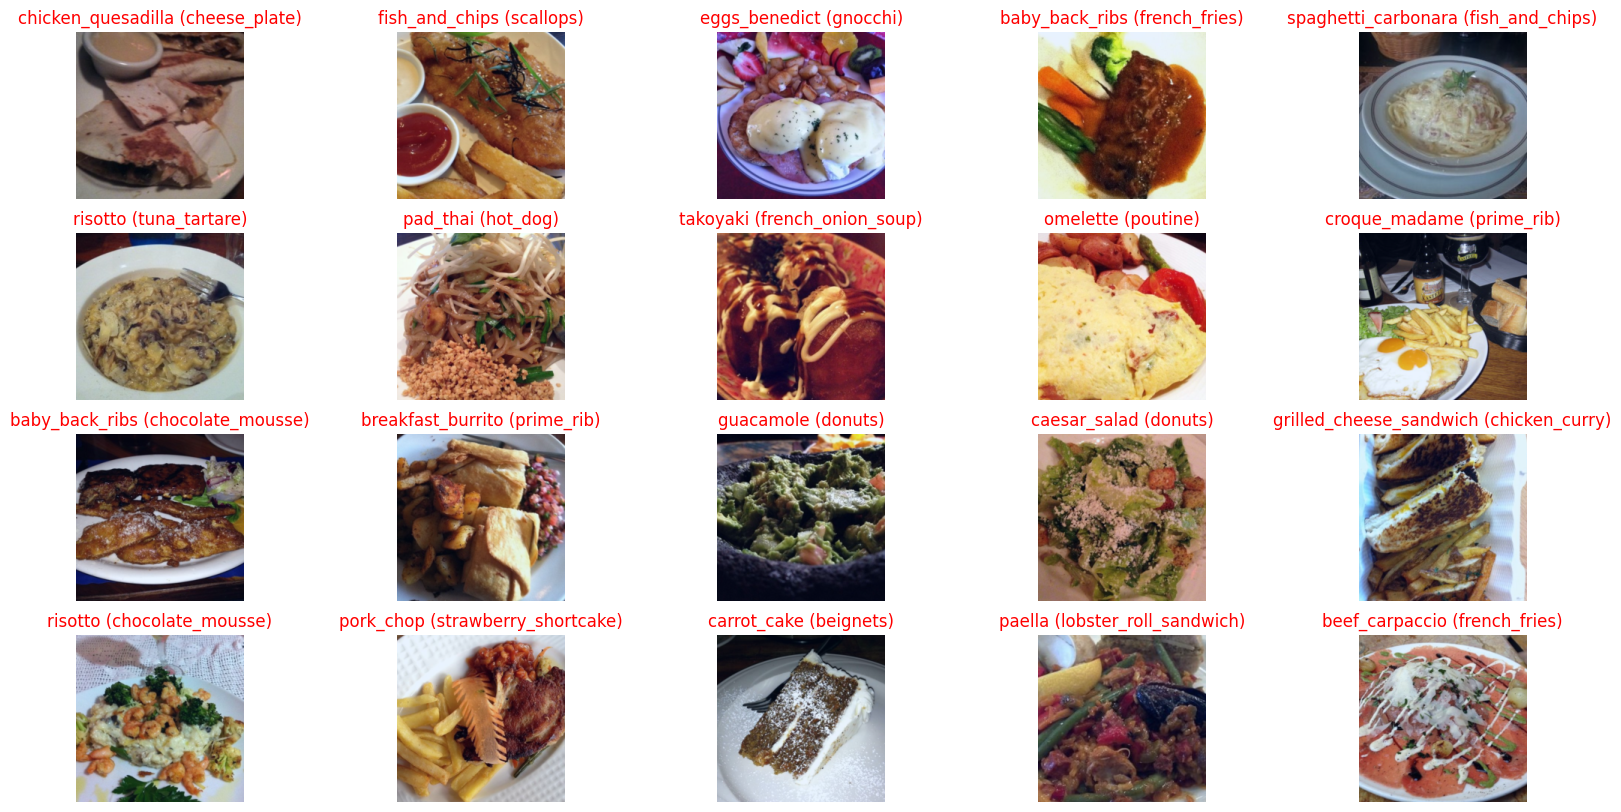

In [137]:
#для efficiennet_b0
predictions_res(modeleff, result_test_data, classes)


EfficientNet прям плохо предсказывает, resnet50 в целом, мне кажется - неплохо, если еще ее обучить подольше, то может стать лучше